# Project 4

With your 30 stocks, implement:

1) time series momentum

2) cross-sectional momentum

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [6]:
warnings.simplefilter(action="ignore", category=FutureWarning)

tickers = [
    'DIS', 'UHS', 'GOOGL', 'LOW', 'BSX', 'JPM', 'EOG', 'SBAC', 'STT', 'DVN',
    'VRTX', 'BK', 'ALL', 'WY', 'OXY', 'ON', 'EXC', 'UAL', 'AKAM', 'SMCI',
    'LYV', 'AMD', 'VLO', 'NI', 'DRI', 'SJM', 'APH', 'MAS', 'CMG', 'TXT'
]



n_tickers = len(tickers)


start_date = '2014-01-01'
end_date = '2023-12-31'

# Download the daily data from stocks
price = yf.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
daily_returns_stocks = price.pct_change()

In [7]:
# Function that returns cumulative returns using momentum time series strategy. Where momentum < 0, it goes Short and when momentum > 0, goes Long. Value Weighted portfolio
# Window represents how many days are used to calculate daily momentum
def timeseries_momentum_strategy(returns,window):
    time_series_momentum = returns.rolling(window=window).mean()
    strategy = np.sign(time_series_momentum)
    
    # This csv have market cap from the selected stocks only
    df_bloomberg = pd.read_csv("data.csv")
    market_cap = df_bloomberg.pivot_table(index="Date",columns="Ticker",values="CUR_MKT_CAP")
    market_cap.index = pd.to_datetime(market_cap.index)
    monthly_market_cap = market_cap.resample("MS").first()

    normalized_monthly_market_cap = monthly_market_cap.divide(monthly_market_cap.sum(axis=1),axis=0)
    # Weights are rebalanced at the end of each month
    value_weights_daily = normalized_monthly_market_cap.reindex(market_cap.index, method="ffill")
    
    weights = strategy*value_weights_daily
    
    strategy_returns = weights.shift(1)*returns
    
    portfolio_return = strategy_returns.sum(axis=1)
    # For the sharpe ratio, it is necessary to annualize the portfolio mean and portfolio std
    mean = portfolio_return.mean()*252
    std = portfolio_return.std()*np.sqrt(252)
    sharpe_ratio = mean / std
    
    return portfolio_return, sharpe_ratio


# Function that returns cumulative returns using cross-sectional momentum strategy. Where rank <= 15, it goes Short and when momentum > 15, goes Long. Value Weighted portfolio
# Window represents how many days are used to calculate daily momentum
# Value-Weighted weights rebalanced with the marketcap of every first day of the month
def cross_sectional_momentum_strategy(returns,window):
    time_series_momentum = returns.rolling(window=window).mean()
    
    cross_sectional_momentum = time_series_momentum.rank(axis=1)
    
    for col in cross_sectional_momentum:
        cross_sectional_momentum[col] = np.where(cross_sectional_momentum[col] <= 15,-1,np.where(cross_sectional_momentum[col]>15,1,0))
        
    strategy = cross_sectional_momentum.copy()
    
    # This csv have market cap from the selected stocks only
    df_bloomberg = pd.read_csv("data.csv")
    market_cap = df_bloomberg.pivot_table(index="Date",columns="Ticker",values="CUR_MKT_CAP")
    market_cap.index = pd.to_datetime(market_cap.index)
    monthly_market_cap = market_cap.resample("MS").first()

    normalized_monthly_market_cap = monthly_market_cap.divide(monthly_market_cap.sum(axis=1),axis=0)
    # Weights are rebalanced at the end of each month
    value_weights_daily = normalized_monthly_market_cap.reindex(market_cap.index, method="ffill")
    
    weights = strategy*value_weights_daily
    
    strategy_returns = weights.shift(1)*returns
    
    portfolio_return = strategy_returns.sum(axis=1)
    # For the sharpe ratio, it is necessary to annualize the portfolio mean and portfolio std
    mean = portfolio_return.mean()*252
    std = portfolio_return.std()*np.sqrt(252)
    sharpe_ratio = mean / std
    
    return portfolio_return,sharpe_ratio


Sharpe Ratio Time Series Momentum:  0.035231749680020866
Sharpe Ratio Cross-Sectional Momentum:  -0.23066156459579254


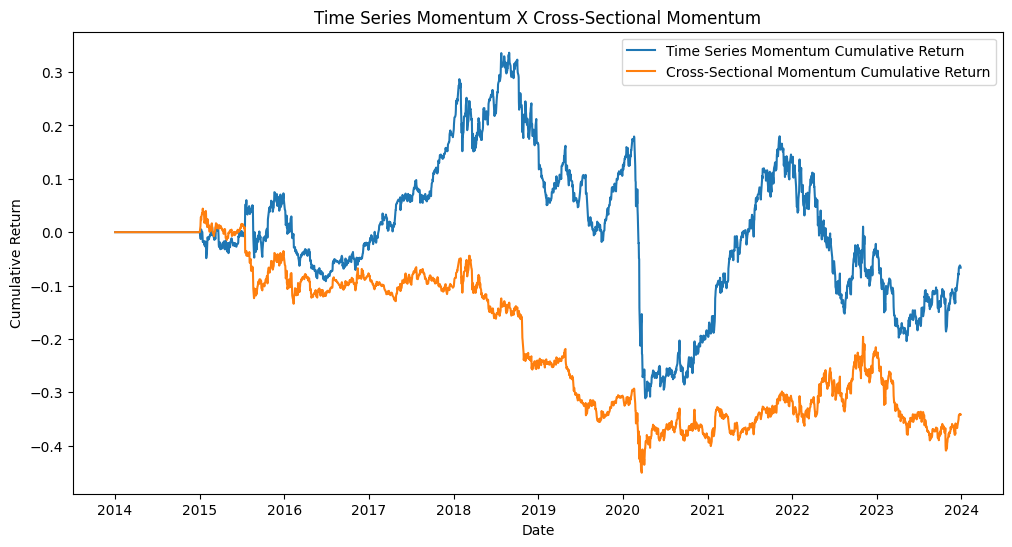

In [11]:
portfolio_returns_time_series_momentum,sharpe_ratio_tsm = timeseries_momentum_strategy(daily_returns_stocks,252)
cumulative_returns_time_series_momentum = (portfolio_returns_time_series_momentum+1).cumprod()-1

portfolio_returns_cross_sectional_momentum, sharpe_ratio_csm = cross_sectional_momentum_strategy(daily_returns_stocks,252)
cumulative_returns_cross_sectional_momentum = (portfolio_returns_cross_sectional_momentum+1).cumprod()-1

print("Sharpe Ratio Time Series Momentum: ", sharpe_ratio_tsm)
print("Sharpe Ratio Cross-Sectional Momentum: ", sharpe_ratio_csm)

plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_time_series_momentum, label="Time Series Momentum Cumulative Return")
plt.plot(cumulative_returns_cross_sectional_momentum, label="Cross-Sectional Momentum Cumulative Return")
plt.title("Time Series Momentum X Cross-Sectional Momentum")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
